**Authors:**

*   Jaume Camps Romaguera - NIA 252021
*   Arol Garcia Rodríguez - NIA 252718
*   Albert Garrell Golobardes - NIA 254635

# **Part1: Text Processing and Exploratory Data Analysis**

### Mounting Drive and path

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/Shareddrives/INFO RETREIVAL/PROJECT/Part 1

/content/drive/Shareddrives/INFO RETREIVAL/PROJECT/Part 1


In [3]:
ls

 data/   IRWA_2024_part_1.ipynb   IRWA-2024-u198736-u198740-u199896-part-1.docx  'Tasks pdf'/


In [4]:
data_path = './data/'

### Load Python packages


In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
#!pip install demoji

In [9]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import pandas as pd
import json
import re
import demoji

### Uploading Data

In this section we are importing all the necessary data for our project!

- 1. Evaluation Data:

In [10]:
evaluation = pd.read_csv(data_path + "./evaluation.csv", sep=";")
evaluation.head(2)

,docId,query_id,label
0,doc_156,1.0,0.0
1,doc_1039,1.0,0.0


- 2. Tweets:

In [11]:
try:
    with open(data_path + "farmers-protest-tweets.json", 'r') as f:
        farmers_protest_tweets = json.load(f)
except json.JSONDecodeError as e:
    # If the file contains multiple JSON objects, we try to parse them individually.
    farmers_protest_tweets = []
    with open(data_path + "farmers-protest-tweets.json", 'r') as f:
        for line in f:
            try:
                farmers_protest_tweets.append(json.loads(line))
            except json.JSONDecodeError as e:
                # If a line cannot be parsed, print an error message and skip it.
                print(f"Error parsing line: {line.strip()}")
                print(f"Error message: {e}")

Let's display the first tweet:

In [12]:
display(farmers_protest_tweets[0])

{'url': 'https://twitter.com/ArjunSinghPanam/status/1364506249291784198',
 'date': '2021-02-24T09:23:35+00:00',
 'content': 'The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. \n\n@narendramodi @DelhiPolice Shame on you. \n\n#ModiDontSellFarmers \n#FarmersProtest \n#FreeNodeepKaur https://t.co/es3kn0IQAF',
 'renderedContent': 'The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. \n\n@narendramodi @DelhiPolice Shame on you. \n\n#ModiDontSellFarmers \n#FarmersProtest \n#FreeNodeepKaur twitter.com/ravisinghka/st…',
 'id': 1364506249291784198,
 'user': {'username': 'ArjunSinghPanam',
  'displayname': 'Arjun Singh Panam',
  'id': 45091142,
  'description': 'Global Citizen, Actor, Director: Sky is the roof above my head, the world is the road I travel, love is my food & mother earth is my bed. Roy in @CosmosMovie',
  'rawDescription':

- 3. Mapping data (ids):

In [13]:
with open(data_path + "tweet_document_ids_map.csv", 'r') as map_ids_file:
    map_ids = pd.read_csv(map_ids_file)
map_ids.head()

,docId,id
0,doc_0,1364506249291784198
1,doc_1,1364506237451313155
2,doc_2,1364506167226032128
3,doc_3,1364505991887347714
4,doc_4,1364505813834989568


### Dictionary with original tweets

As a first step, we are creating a dictionary with all tweet important information: <br>
- tweet
- hashtags
- url
- date
- likes
- retweets

In this dictionary, we are storing the original tweet, without any pre-processing.

In [14]:
def extract_hashtags(line):
    hashtags = re.findall(r'#\w+', line)

    # Split the line into words
    words = line.split()

    # Return the cleaned line and the list of hashtags
    return ' '.join(words), hashtags


In [15]:
original_tweets_dict = {}

for i in range(len(farmers_protest_tweets)):
    try:
        id_num = farmers_protest_tweets[i]['id']
        doc_id = map_ids.loc[map_ids['id'] == id_num, 'docId'].values[0]

        line = farmers_protest_tweets[i]['content']

        tweet, hashtags = extract_hashtags(line)

        date = farmers_protest_tweets[i]['date']
        likes = farmers_protest_tweets[i]['likeCount']
        retweets = farmers_protest_tweets[i]['retweetCount']
        url = farmers_protest_tweets[i]['url']

        original_tweets_dict[doc_id] = {
            'tweet': tweet,
            'hashtags': hashtags,
            'date': date,
            'likes': likes,
            'retweets': retweets,
            'url': url
        }
    except:
        continue


Let's show how 'doc_0' looks like:

In [16]:
original_tweets_dict['doc_0']

{'tweet': 'The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. @narendramodi @DelhiPolice Shame on you. #ModiDontSellFarmers #FarmersProtest #FreeNodeepKaur https://t.co/es3kn0IQAF',
 'hashtags': ['#ModiDontSellFarmers', '#FarmersProtest', '#FreeNodeepKaur'],
 'date': '2021-02-24T09:23:35+00:00',
 'likes': 0,
 'retweets': 0,
 'url': 'https://twitter.com/ArjunSinghPanam/status/1364506249291784198'}

### Dictionary with processed tweets

As a next step, we are preprocessing the text as follows: <br>
- lower case
- extracting hashtags (we are saving it into another field as we want to differentiate them from the rest)
- Remove any symbol that does not match with a to z (character), 0 to 9 (digit) and white space character
- Remove stopwords
- Stemming
- URL removal (just for tweet content)<br>

‼️ The above process is done with tweet itself and hashtags separately, so that hashtags words are preprocessed but not included into the tweet

In [21]:
def build_terms(line):
    """
    Preprocess the text (tweet) by removing stop words, punctuation (but keeping numbers), URLs,
    stemming, transforming to lowercase, and extracting hashtags. The hashtags are excluded
    from the preprocessed text.

    Argument:
    line -- string (text) to be preprocessed

    Returns:
    preprocessed_line -- a list of tokens corresponding to the input text after preprocessing
    hashtags -- a list of extracted hashtags
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    # Transform to lowercase
    line = line.lower()

    # HASHTAGS

    # Extract hashtags (keeping the # symbol)
    hashtags = re.findall(r'#\w+', line)
    # Remove punctuation but keep numbers
    hashtags = [re.sub(r'[^a-z0-9\s]', '', word) for word in hashtags]
    # Remove stopwords
    hashtags = [word for word in hashtags if word not in stop_words]
    # Perform stemming
    hashtags = [stemmer.stem(word) for word in hashtags]
    # Remove empty strings (in case stemming or other operations result in an empty hashtag)
    hashtags = [word for word in hashtags if word]

    # LINE

    # Remove emojis using demoji
    line = demoji.replace(line, " ")
    # Remove hashtags from the text --> remove all the word
    line = re.sub(r'#\w+', '', line)
    # Remove URLs
    line = re.sub(r'http\S+|www\S+|https\S+', '', line)
    # Remove punctuation but keep numbers (and hashtags are already removed)
    line = re.sub(r'[^a-z0-9\s]', '', line)
    # Tokenize the text to get a list of terms
    line = line.split()
    # Remove the word amp since & it is parsed as &amp and it is one of the most frequent words!
    line = [word for word in line if word != 'amp']
    # Remove stopwords
    line = [word for word in line if word not in stop_words]
    # Perform stemming
    line = [stemmer.stem(word) for word in line]

    # Return preprocessed text and hashtags
    return line, hashtags # return the preprocessed tweet content and hashtags

Here is an example of the output:

In [22]:
tweet, hashtags = build_terms(farmers_protest_tweets[0]['content'])
print(tweet)
print(hashtags)

['world', 'progress', 'indian', 'polic', 'govt', 'still', 'tri', 'take', 'india', 'back', 'horrif', 'past', 'tyranni', 'narendramodi', 'delhipolic', 'shame']
['modidontsellfarm', 'farmersprotest', 'freenodeepkaur']


Finally, let's create a dictionary to store the preprocessed tweets contents and hashtags:

In [23]:
processed_tweets_dict = {}

for i in range(len(farmers_protest_tweets)):
    try:
        id_num = farmers_protest_tweets[i]['id']
        doc_id = map_ids.loc[map_ids['id'] == id_num, 'docId'].values[0]

        line = farmers_protest_tweets[i]['content']

        tweet, hashtags = build_terms(line)

        processed_tweets_dict[doc_id] = {
            'tweet': tweet,
            'hashtags': hashtags,
        }
    except:
        continue

Here we can see the difference between the original and the preprocessed tweets and hashtags:

In [24]:
print(original_tweets_dict['doc_1'])
print(processed_tweets_dict['doc_1'])

{'tweet': "#FarmersProtest #ModiIgnoringFarmersDeaths #ModiDontSellFarmers @Kisanektamorcha Farmers constantly distroying crops throughout India. Really, it's hearts breaking...we care about our crops like our children. And govt. agriculture minister is laughing on us🚜🌾WE WILL WIN💪 https://t.co/kLspngG9xE", 'hashtags': ['#FarmersProtest', '#ModiIgnoringFarmersDeaths', '#ModiDontSellFarmers'], 'date': '2021-02-24T09:23:32+00:00', 'likes': 0, 'retweets': 0, 'url': 'https://twitter.com/PrdeepNain/status/1364506237451313155'}
{'tweet': ['kisanektamorcha', 'farmer', 'constantli', 'distroy', 'crop', 'throughout', 'india', 'realli', 'heart', 'breakingw', 'care', 'crop', 'like', 'children', 'govt', 'agricultur', 'minist', 'laugh', 'us', 'win'], 'hashtags': ['farmersprotest', 'modiignoringfarmersdeath', 'modidontsellfarm']}


# Part 2: Exploratory Data Analysis

In [ ]:
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

**We should include hastags into the analysis --> join tweet and hashtags**

In [ ]:
# Initialize Spacy for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

# Prepare data for EDA
original_tweets_df = pd.DataFrame.from_dict(original_tweets_dict, orient='index')
processed_tweets_df = pd.DataFrame.from_dict(processed_tweets_dict, orient='index')

# 1. Word Count Distribution
def word_count_distribution():
    original_tweets_df['word_count'] = processed_tweets_df['tweet'].apply(lambda x: len(' '.join(x).split()))

    plt.figure(figsize=(10, 6))
    sns.histplot(original_tweets_df['word_count'], bins=30, kde=True)
    plt.title('Word Count Distribution in Tweets')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()

# 2. Average Sentence Length
def average_sentence_length():
    avg_length = original_tweets_df['word_count'].mean()
    print(f'Average Sentence Length: {avg_length:.2f} words')

# 3. Vocabulary Size
def vocabulary_size():
    all_words = [word for tweet in processed_tweets_df['tweet'] for word in tweet]
    vocab_size = len(set(all_words))
    print(f'Vocabulary Size: {vocab_size} unique words')

# 4. Ranking of Tweets by Retweets
def ranking_by_retweets():
    top_retweets = original_tweets_df[['tweet', 'retweets']].sort_values(by='retweets', ascending=False).head(10)
    print('Top 10 Tweets by Retweets:')
    print(top_retweets)

# 5. Word Cloud for Most Frequent Words
def generate_wordcloud():
    # Flatten the list of lists into a single list of words
    all_words = [word for tweet in processed_tweets_df['tweet'] for word in tweet]

    # Join the words into a single string
    all_words_string = ' '.join(all_words)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words_string)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# 6. Top n Most Frequent Words
def most_frequent_words(n=50):
    # Flatten the list of lists into a single list of words
    all_words = [word for tweet in processed_tweets_df['tweet'] for word in tweet]

    # Use Counter to count the frequency of each word
    word_counts = Counter(all_words)

    # Get the top n most frequent words
    most_common_words = word_counts.most_common(n)

    # Convert the result into a DataFrame for easier viewing
    word_freq_df = pd.DataFrame(most_common_words, columns=['Word', 'Count'])

    print(f'Top {n} Most Frequent Words:')
    print(word_freq_df)

    # Plot the results
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Word', data=word_freq_df)
    plt.title(f'Top {n} Most Frequent Words')
    plt.show()

# 7. Named Entity Recognition (NER)
def entity_recognition():
    entities = []
    for tweet in processed_tweets_df['tweet']:
        # Join the list of words into a single string
        tweet_text = ' '.join(tweet)
        doc = nlp(tweet_text)  # Process the tweet text with Spacy
        for ent in doc.ents:
            entities.append((ent.text, ent.label_))

    entity_df = pd.DataFrame(entities, columns=['Entity', 'Label'])
    entity_counts = entity_df['Label'].value_counts()

    print('Entity Counts by Type:')
    print(entity_counts)

    plt.figure(figsize=(10, 6))
    sns.countplot(y='Label', data=entity_df, order=entity_counts.index)
    plt.title('Entity Recognition in Tweets')
    plt.show()

# 8. Hashtag Count Distribution
def hashtag_count_distribution():
    processed_tweets_df['hashtag_count'] = processed_tweets_df['hashtags'].apply(lambda x: len(x))

    plt.figure(figsize=(10, 6))
    sns.histplot(processed_tweets_df['hashtag_count'], bins=25, kde=False)
    plt.title('Hashtag Count Distribution in Tweets')
    plt.xlabel('Number of Hashtags')
    plt.ylabel('Frequency')
    plt.show()

# 9. Most Frequent Hashtags
def most_frequent_hashtags(n=10):
    # Flatten the list of hashtags into a single list
    all_hashtags = [hashtag for hashtags in processed_tweets_df['hashtags'] for hashtag in hashtags]

    # Use Counter to count the frequency of each hashtag
    hashtag_counts = Counter(all_hashtags)

    # Get the top n most frequent hashtags
    most_common_hashtags = hashtag_counts.most_common(n)

    # Convert the result into a DataFrame for easier viewing
    hashtag_freq_df = pd.DataFrame(most_common_hashtags, columns=['Hashtag', 'Count'])

    print(f'Top {n} Most Frequent Hashtags:')
    print(hashtag_freq_df)

    # Plot the results
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Hashtag', data=hashtag_freq_df)
    plt.title(f'Top {n} Most Frequent Hashtags')
    plt.show()

# 10. Word Cloud for Hashtags
def generate_hashtag_wordcloud():
    # Flatten the list of hashtags into a single list
    all_hashtags = [hashtag for hashtags in processed_tweets_df['hashtags'] for hashtag in hashtags]

    # Join the hashtags into a single string
    hashtag_string = ' '.join(all_hashtags)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(hashtag_string)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Hashtag Word Cloud')
    plt.show()


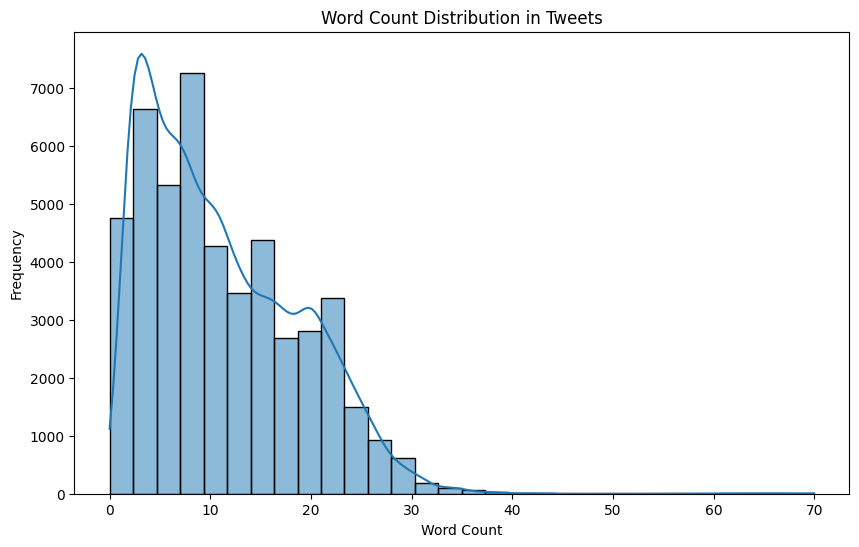

In [ ]:
word_count_distribution()

It looks like a Poisson Distribution, given the high amount of data, this type of distribution makes sense given the Central Limit Theorem (CLT).

In [ ]:
average_sentence_length()

Average Sentence Length: 11.18 words


In [ ]:
vocabulary_size()

Vocabulary Size: 32248 unique words


In [ ]:
ranking_by_retweets()

Top 10 Tweets by Retweets:
                                                       tweet  retweets
doc_3203   There's a #FarmersProtest happening in Germany...      6164
doc_38410  disha ravi, a 21-year-old climate activist, ha...      4673
doc_38012  Disha Ravi broke down in court room and told j...      3742
doc_46206  Farmers are so sweet. Y’all have to see this @...      3332
doc_27071  india is targeting young women to silence diss...      3230
doc_45142  Bollywood has betrayed Panjab &amp; the farmer...      3182
doc_35993  Please, where did you get your PhD from? Anti-...      2495
doc_9846   This is Revolution. More than 2.25lac people a...      2258
doc_38262  Wish you fly over the Delhi border and look at...      2208
doc_41472  They went after our grandparents. #GurmukhSing...      1933


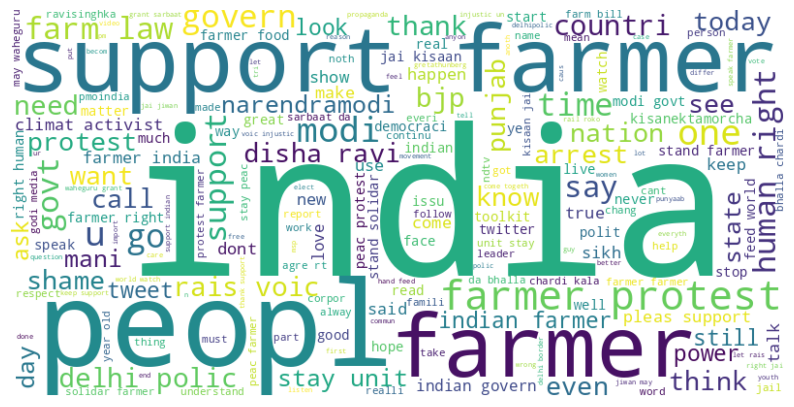

In [ ]:
generate_wordcloud()

Top 50 Most Frequent Words:
            Word  Count
0         farmer  15789
1          india   6539
2        support   5985
3        protest   4698
4          right   3566
5          peopl   3503
6         indian   2908
7           modi   2773
8         govern   2724
9            law   2545
10          govt   2319
11         stand   2202
12           bjp   2190
13         thank   2117
14         pleas   2042
15         world   1974
16          dont   1970
17          farm   1964
18          need   1916
19          like   1914
20           one   1862
21            us   1846
22        arrest   1809
23         delhi   1708
24         human   1671
25          voic   1638
26         polic   1624
27          make   1601
28           let   1596
29           get   1556
30            go   1479
31          time   1435
32       countri   1429
33      activist   1395
34          unit   1359
35           day   1356
36          peac   1356
37         fight   1346
38          stop   1342
39          

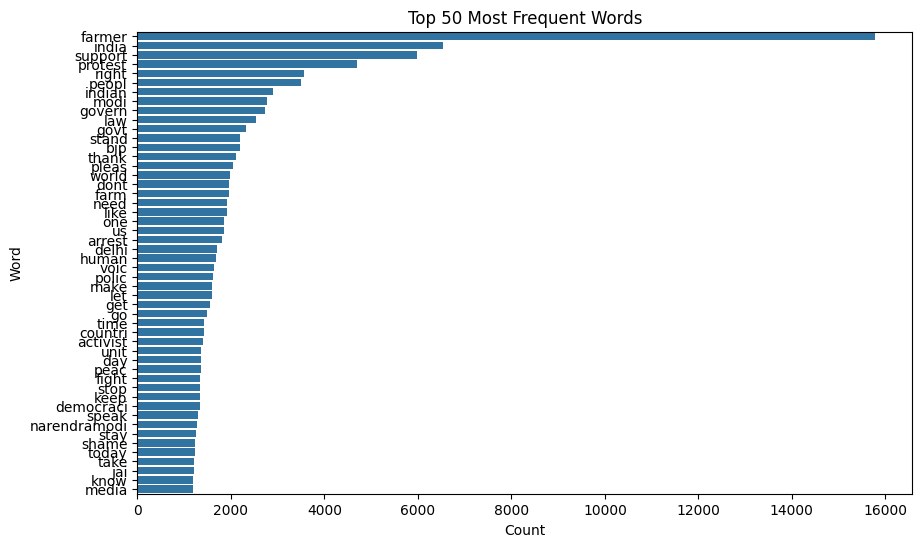

In [ ]:
most_frequent_words()

Entity Counts by Type:
Label
PERSON         15987
GPE             9691
ORG             9387
CARDINAL        8573
DATE            5090
NORP            4593
ORDINAL          608
PRODUCT          534
TIME             332
QUANTITY         228
FAC              177
LOC              115
WORK_OF_ART       47
LANGUAGE          40
EVENT             40
MONEY             35
LAW               29
PERCENT           12
Name: count, dtype: int64


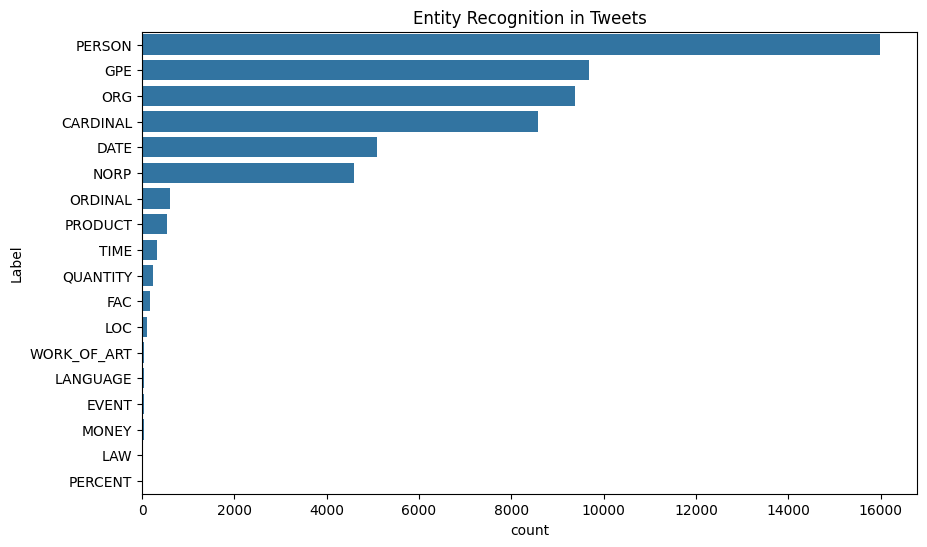

In [ ]:
entity_recognition()

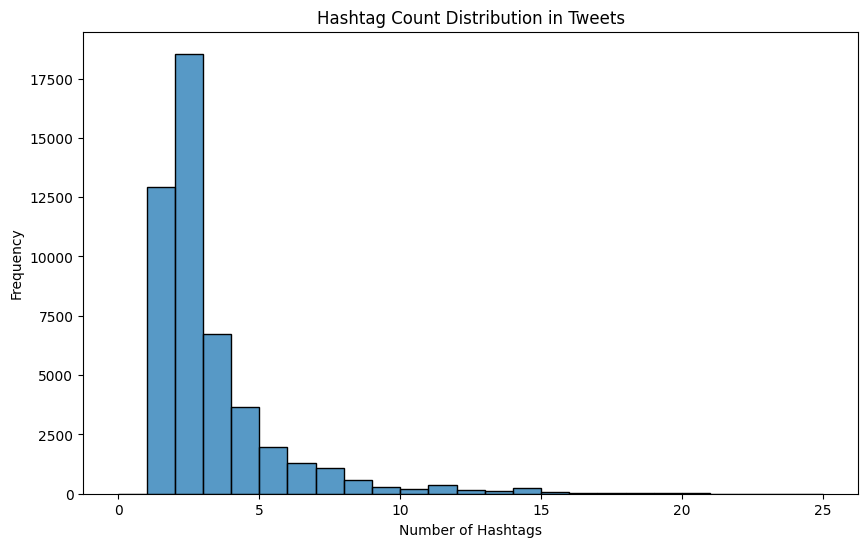

In [ ]:
hashtag_count_distribution()

Top 10 Most Frequent Hashtags:
                Hashtag  Count
0        farmersprotest  50458
1   releasedetainedfarm   2439
2      indiabeingsilenc   2146
3      farmersmakeindia   2139
4             disharavi   2007
5  mahapanchayatrevolut   1952
6    repealonlywayahead   1764
7                farmer   1614
8     pagdisambhaljatta   1590
9         standwithfarm   1391


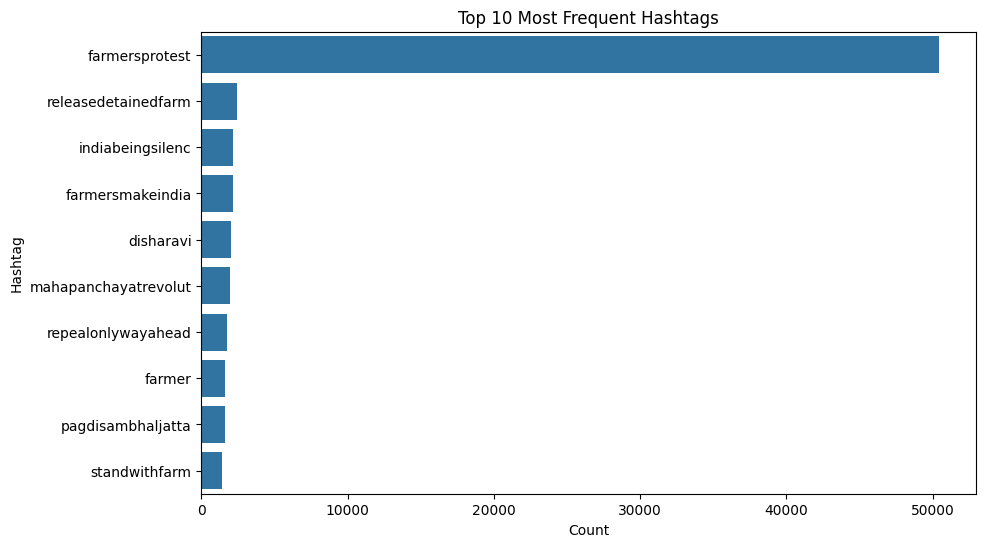

In [ ]:
most_frequent_hashtags()

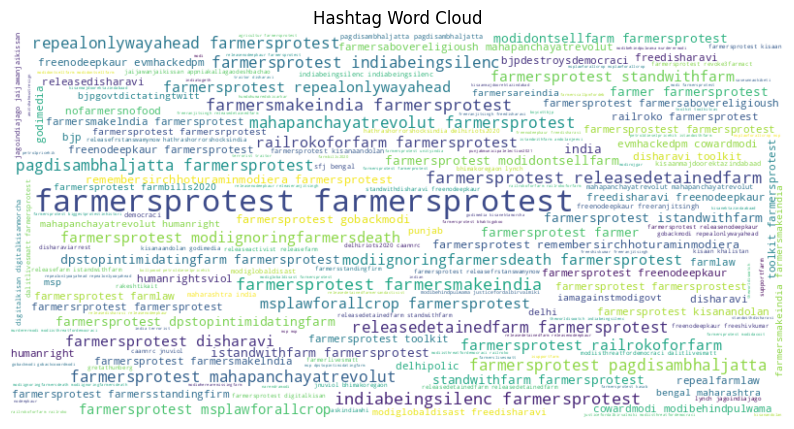

In [ ]:
generate_hashtag_wordcloud()